# VAE for anomaly detection of diverse time-series sensor data
### Using reconstruction error for classification
Note: Error below refers to reconstruction error as defined based on the evidence lower bound (ELBO). The reconstruction error (called gen_err in VAE1DLoss) is the negative log probability of x (input) given z (latent representation). The sum of this error and the KL divergence is what is minimized in training of the variational autoencoder.

Build the model for 512 time points per cycle with 14 sensors. Trained on non-fault data to learn a normal expectation.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
from IPython.core.debugger import set_trace

In [4]:
import sys
sys.path.append('../src/')
from demo_week3 import *
device

device(type='cuda', index=0)

In [5]:
desc

'accumulator'

In [6]:
print(f"Time-series size = {size}, number of sensors = {n_channels}, "
      f"latent size = {n_latent}")

Time-series size = 512, number of sensors = 14, latent size = 50


Load the best parameters from training.

In [7]:
model = load_checkpoint()

Checkpoint Performance:
Validation loss: 14.268
Epoch: 210


In [8]:
params = model.demo()

Input size: torch.Size([1, 14, 512])
Encoded size: torch.Size([1, 1024, 4])
Latent size: torch.Size([1, 50, 1])
Decoded (output) size: torch.Size([1, 14, 512])


In [9]:
X, E, L, D = [param.cpu().detach().numpy() for param in params]
error = np.power((X - D), 2).sum() / 2
print(f"Error of random data = {error:.3f}")

Error of random data = 694.799


In [10]:
X[:, :4, :4]

array([[[0.5030513 , 0.7833683 , 0.28159168, 0.86724657],
        [0.7507961 , 0.10005765, 0.18530545, 0.3824699 ],
        [0.14576694, 0.26603633, 0.9660105 , 0.3960565 ],
        [0.605988  , 0.29978672, 0.73545766, 0.40469134]]], dtype=float32)

In [11]:
D[:, :4, :4]

array([[[ 0.19245797,  0.19725236,  0.21389642,  0.27223212],
        [ 0.30888316,  0.04787923, -0.02817911, -0.0327672 ],
        [ 0.36408547,  0.21791472,  0.23493646,  0.14581583],
        [ 0.2254411 ,  0.36491367,  0.40511155,  0.5998299 ]]],
      dtype=float32)

Next we need to load the datasets of sensors readings.

In [12]:
data_path = Path(f'../data/hydraulic/{desc}')
train_dl, val_dl, test_dl = load_datasets(data_path)

In [13]:
print(len(train_dl), len(val_dl), len(test_dl))

27 7 1157


Let's get some random samples from the dataset for examples and generate new versions.

In [14]:
data, targets = get_random_samples(100)

In [15]:
classes = list_target_classes(test_dl)

0 = fail
1 = norm


In [16]:
targets = targets.cpu().numpy()
targets[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 0])

In [17]:
print('normals = ', targets.sum())

normals =  31


In [18]:
print('failures = ', len(targets) - targets.sum())

failures =  69


In [19]:
criterion = VAE1DLoss()
criterion = criterion.to(device)

In [20]:
model.eval()
with torch.no_grad():
    # Generate
    data = data.to(device)
    gen_data, mu, logvar = model(data)
    loss, loss_desc = criterion(gen_data, data, mu, logvar, reduce=False)
    

In [21]:
gen_err = -loss_desc['logp']
gen_err[:10]

tensor([ 22.6857,  88.4215,   5.0520,  15.4814, 116.9828,  34.1560,   5.7411,
        117.0397,  23.5104,  52.5216], device='cuda:0')

[[ 0.06085607 -0.04645628 -0.02802303 -0.10501722 -0.01963192]
 [-0.02327551  0.00285482  0.00578736  0.05504346  0.04196847]
 [ 0.1436665   0.02609622  0.05142498  0.0764336   0.05425024]
 [ 0.0708876  -0.0503957   0.04489911  0.04464728  0.12651855]
 [ 0.12087733 -0.05502282 -0.0698273   0.01622568 -0.01768017]]
Error = 22.685747146606445


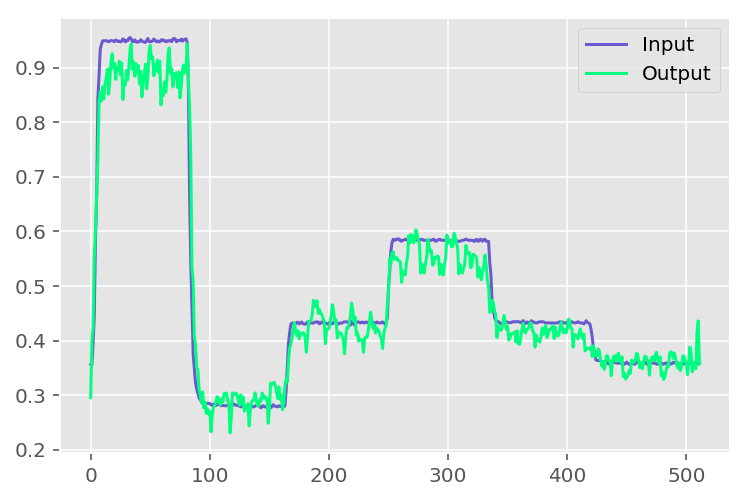

In [22]:
idx = 0
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :], label='Input', c='slateblue')
plt.plot(gen_sample[0, :], label='Output', c='springgreen')
plt.legend()
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"Error = {np.power((sample - gen_sample), 2).sum() / 2}")

[[ 0.06085607 -0.04645628 -0.02802303 -0.10501722 -0.01963192]
 [-0.02327551  0.00285482  0.00578736  0.05504346  0.04196847]
 [ 0.1436665   0.02609622  0.05142498  0.0764336   0.05425024]
 [ 0.0708876  -0.0503957   0.04489911  0.04464728  0.12651855]
 [ 0.12087733 -0.05502282 -0.0698273   0.01622568 -0.01768017]]
Error = 22.685747146606445


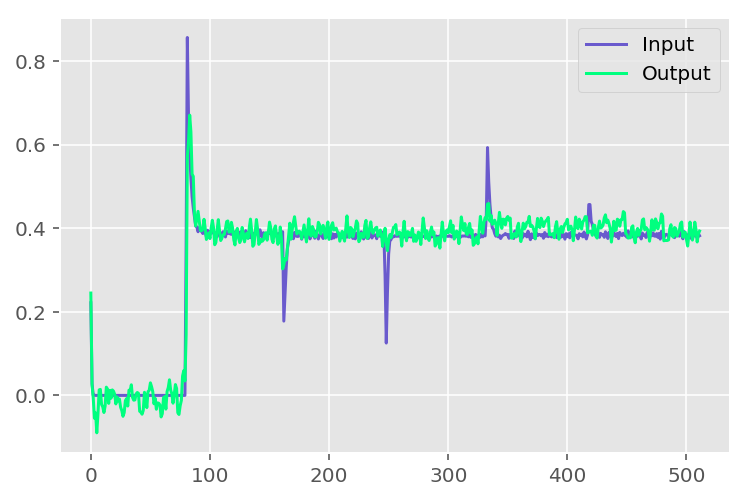

In [23]:
idx = 0
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[1, :], label='Input', c='slateblue')
plt.plot(gen_sample[1, :], label='Output', c='springgreen')
plt.legend()
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"Error = {np.power((sample - gen_sample), 2).sum() / 2}")

In [24]:
err = np.zeros(targets.shape)
for i, target in enumerate(targets):
    err[i] = -loss_desc['logp'][i]
    print(f"Target = {target}, Error = {err[i]:.3f}")
    if i > 10:
        break

Target = 0, Error = 22.686
Target = 0, Error = 88.421
Target = 1, Error = 5.052
Target = 0, Error = 15.481
Target = 0, Error = 116.983
Target = 1, Error = 34.156
Target = 1, Error = 5.741
Target = 0, Error = 117.040
Target = 1, Error = 23.510
Target = 0, Error = 52.522
Target = 0, Error = 39.431
Target = 0, Error = 55.372


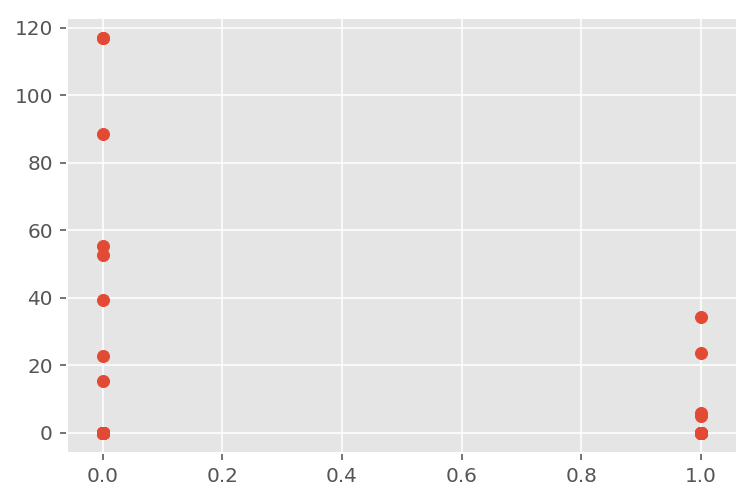

In [25]:
plt.scatter(targets, err)

Show the data plots.

Let's score the success of the recreation and look for outliers.

In [26]:
scores = compute_scores(test_dl, model, criterion)

100%|██████████| 1157/1157 [00:07<00:00, 146.26it/s]


In [27]:
test_means = pd.DataFrame()
for (name, cls), item in scores.items():
    test_means.loc[name, cls] = np.array(item).mean()

print("###################### TEST MEANS #####################")
print(test_means)

###################### TEST MEANS #####################
             fail       norm
loss   107.243702  73.272715
KL      69.908821  45.311792
error   37.334881  27.960923


In [28]:
val_means = pd.DataFrame()
for (name, cls), item in compute_scores(val_dl, model, criterion).items():
    val_means.loc[name, cls] = np.array(item).mean()

print("###################### VAL MEANS #####################")
print(val_means)

100%|██████████| 7/7 [00:01<00:00,  5.62it/s]

###################### VAL MEANS #####################
            norm
loss   71.878251
KL     47.277126
error  24.601126


In [29]:
train_means = pd.DataFrame()
for (name, cls), item in compute_scores(train_dl, model, criterion).items():
    train_means.loc[name, cls] = np.array(item).mean()

print("###################### TRAIN MEANS #####################")
print(train_means)

100%|██████████| 27/27 [00:04<00:00,  5.90it/s]

###################### TRAIN MEANS #####################
            norm
loss   75.999672
KL     46.132864
error  29.866807


Let's calculate F1 score to judge performance.

In [30]:
from sklearn.metrics import f1_score

In [31]:
scores.keys()

dict_keys([('loss', 'fail'), ('loss', 'norm'), ('KL', 'fail'), ('KL', 'norm'), ('error', 'fail'), ('error', 'norm')])

In [32]:
print(len(scores[('error', 'norm')]), len(scores[('error', 'fail')]))

349 808


In [33]:
# simple definition of the threshold as mean between sets
threshold = (np.mean(scores['error', 'fail']) +
             np.mean(scores['error', 'norm'])) / 2
print('mean threshold:', threshold)
# maximum 95% percentile of normal as threshold
# threshold = np.percentile(scores['error', 'norm'], 95)
# print('95th percentile threshold:', threshold)

mean threshold: 32.64790197189493


In [34]:
t_scores = scores.copy()
t_scores[('error', 'fail')] = (t_scores[('error', 'fail')] > threshold)
t_scores[('error', 'norm')] = (t_scores[('error', 'norm')] > threshold)

t_score = []
t_score.extend(t_scores[('error', 'fail')])
t_score.extend(t_scores[('error', 'norm')])
t_score = np.array(t_score)

y_true = []
y_true.extend([True] * len(t_scores[('error', 'fail')]))
y_true.extend([False] * len(t_scores[('error', 'norm')]))
y_true = np.array(y_true)

In [35]:
t_corr = t_score == y_true
t_corr.sum() / len(t_corr)

0.5177182368193605

In [36]:
f1_score(y_true, t_score)

0.5499999999999999

In [37]:
np.mean(scores['error', 'norm'])

27.960922911037347

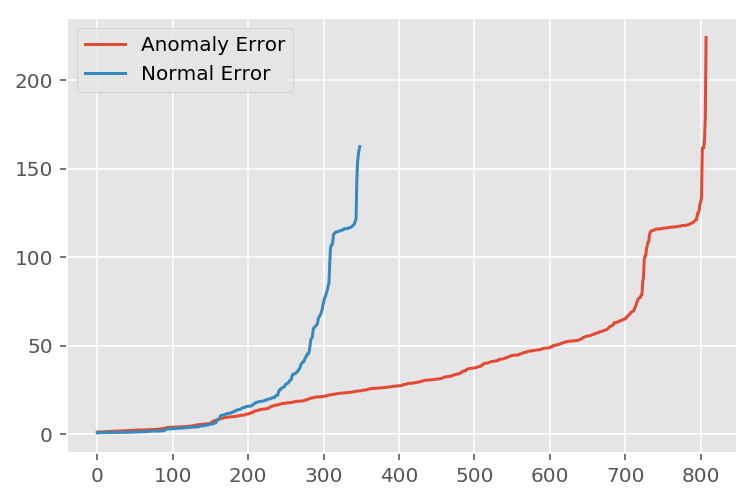

In [38]:
normaly = sorted(scores[('error', 'norm')])
anomaly = sorted(scores[('error', 'fail')])
plt.plot(anomaly, label='Anomaly Error')
plt.plot(normaly, label='Normal Error')
plt.legend()

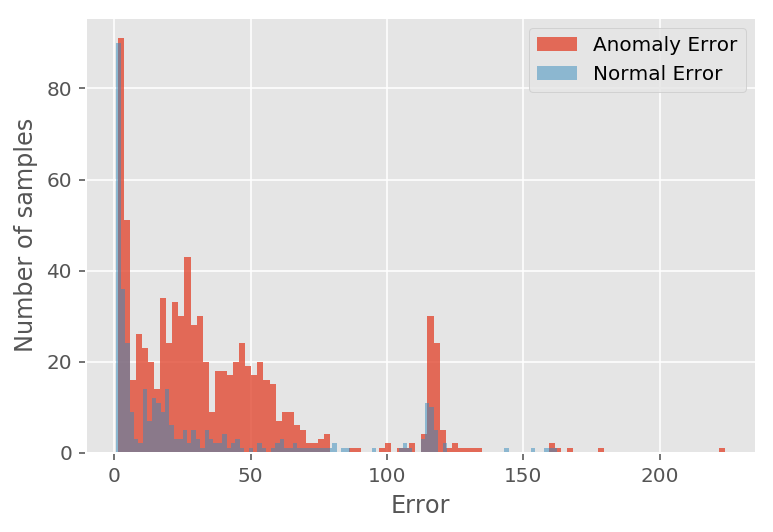

In [39]:
plt.hist(anomaly, label='Anomaly Error', bins=100, alpha=0.8)
plt.hist(normaly, label='Normal Error', bins=100, alpha=0.5)
plt.xlabel('Error')
plt.ylabel('Number of samples')
plt.legend()

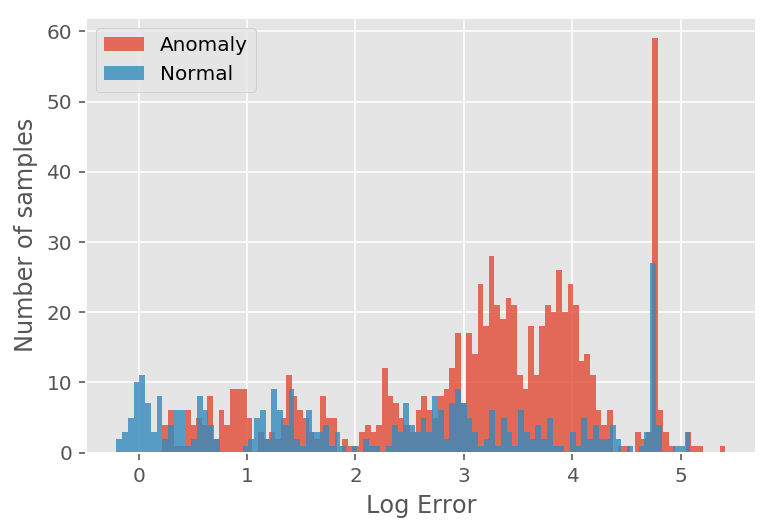

In [40]:
# With log values
plt.hist(np.log(anomaly), label='Anomaly', bins=100, alpha=0.8)
plt.hist(np.log(normaly), label='Normal', bins=100, alpha=0.8)
plt.xlabel('Log Error')
plt.ylabel('Number of samples')
plt.legend()

In [41]:
normalx = np.random.rand(len(normaly))
anomalx = np.random.rand(len(anomaly))

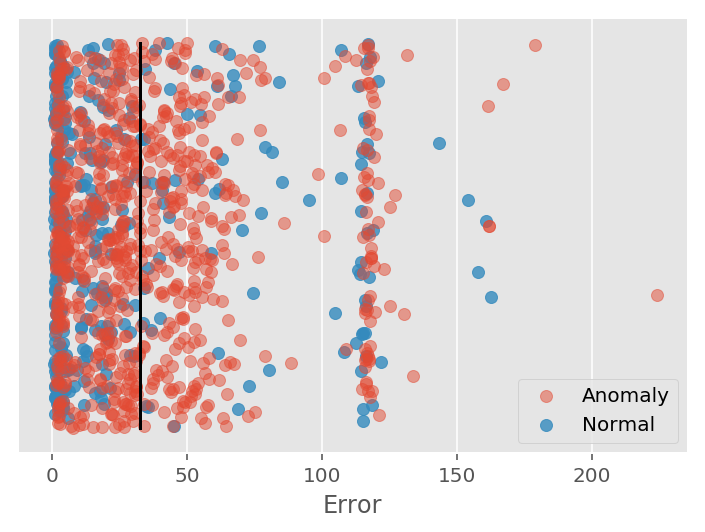

In [42]:
plt.scatter(anomaly, anomalx, label='Anomaly',
            alpha=0.5, zorder=2)
plt.scatter(normaly, normalx, label='Normal',
            alpha=0.8)
plt.plot([threshold, threshold], [0, 1], 'k-')
plt.gca().get_yaxis().set_visible(False)
plt.xlabel('Error')
plt.legend()

Try fitting a normal distribution to the validation reconstruction error to define a threshold.

In [43]:
val_scores = compute_scores(val_dl, model, criterion)

100%|██████████| 7/7 [00:01<00:00,  5.56it/s]


In [44]:
val_scores.keys()

dict_keys([('loss', 'norm'), ('KL', 'norm'), ('error', 'norm')])

[0.8244032263755798, 0.8520482182502747, 0.8531434535980225, 0.9244909286499023, 0.945241391658783]
mean=24.60, stdev=35.40


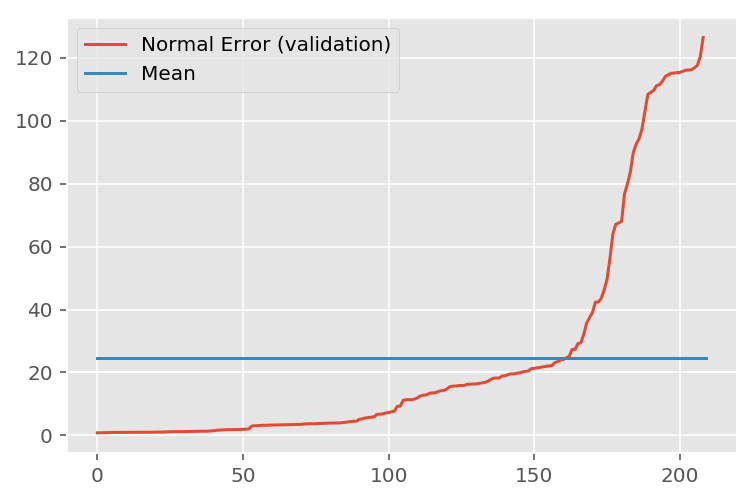

In [45]:
val_norm = sorted(val_scores[('error', 'norm')])
print(val_norm[:5])
mean = np.mean(val_norm)
std = np.std(val_norm)
print('mean={:.2f}, stdev={:.2f}'.format(mean, std))
plt.plot(val_norm, label= 'Normal Error (validation)')
plt.plot([0, len(val_norm)], [mean, mean], label='Mean')
plt.legend()

Implement PCA to visualize the latent space.

In [46]:
data.shape

torch.Size([100, 14, 512])

In [47]:
latents, targets = compute_latents(test_dl, model)

  8%|▊         | 95/1157 [00:00<00:20, 50.80it/s]


In [48]:
from sklearn.decomposition import PCA

In [49]:
pca = PCA(n_components=2)

In [50]:
lat_pca = pca.fit_transform(latents)

In [51]:
lat_pca.shape

(101, 2)

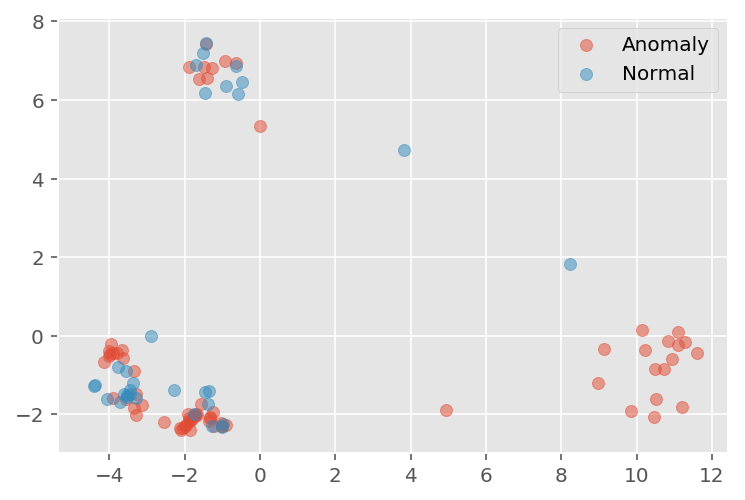

In [52]:
fail_mask = targets == 0
norm_mask = targets == 1
plt.scatter(lat_pca[fail_mask, 0], lat_pca[fail_mask, 1],
           label='Anomaly', alpha=0.5)
plt.scatter(lat_pca[norm_mask, 0], lat_pca[norm_mask, 1],
            label='Normal', alpha=0.5)
plt.legend()

In [53]:
pca.explained_variance_ratio_

array([0.45252967, 0.18949822], dtype=float32)

Cluster the latent space into kmeans clusters.

In [54]:
from sklearn.cluster import KMeans

In [55]:
kmeans = KMeans(3)

In [56]:
lat_k = kmeans.fit_transform(latents)

In [57]:
lat_k.shape

(101, 3)

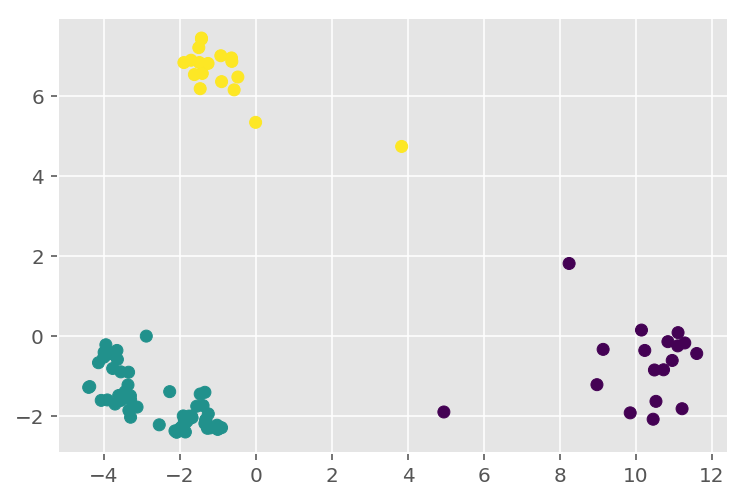

In [58]:
plt.scatter(lat_pca[:, 0], lat_pca[:, 1], c=kmeans.labels_)

Compare the pca plots for validation and training sets.

100%|██████████| 27/27 [00:04<00:00,  6.02it/s]


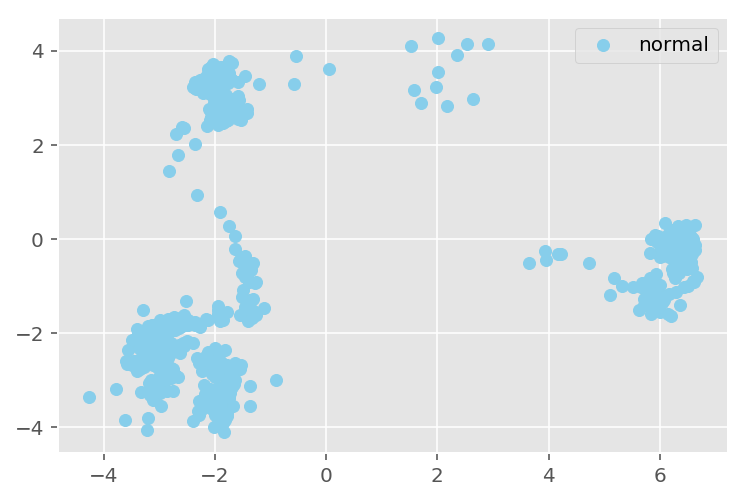

In [59]:
latents, targets = compute_latents(train_dl, model)
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(latents)
plt.scatter(lat_pca[:, 0], lat_pca[:, 1],
            c='skyblue', label='normal')
plt.legend()

100%|██████████| 7/7 [00:01<00:00,  5.64it/s]


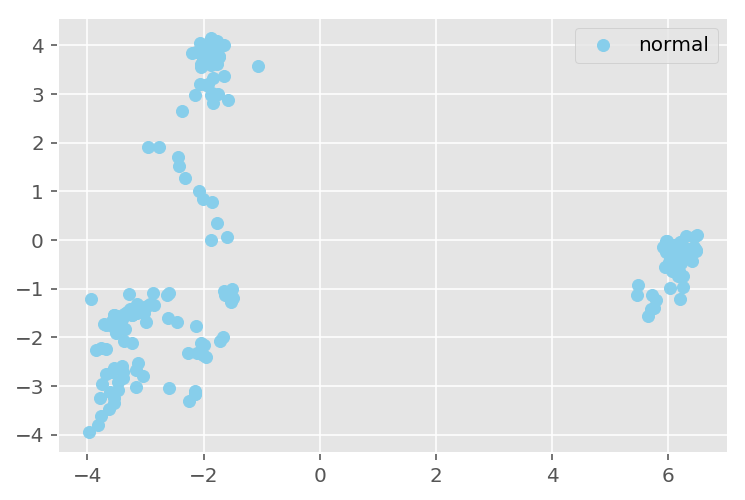

In [60]:
latents, targets = compute_latents(val_dl, model)
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(latents)
plt.scatter(lat_pca[:, 0], lat_pca[:, 1],
            c='skyblue', label='normal')
plt.legend()

Combine the validation plot with the test plot to understand global structure.

In [61]:
latents, targets = compute_latents(train_dl, model)
pca = PCA(n_components=2)
train_pca = pca.fit_transform(latents)

100%|██████████| 27/27 [00:04<00:00,  5.92it/s]


In [62]:
latents, targets = compute_latents(val_dl, model)
val_pca = pca.transform(latents)

100%|██████████| 7/7 [00:01<00:00,  5.66it/s]


In [63]:
latents, targets = compute_latents(test_dl, model)
test_pca = pca.transform(latents)
fail_mask = targets == 0
norm_mask = targets == 1

  8%|▊         | 96/1157 [00:00<00:21, 49.39it/s]


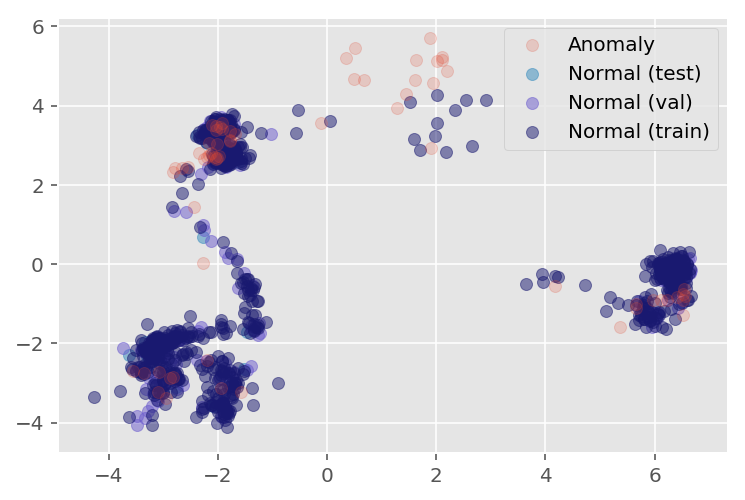

In [64]:
plt.scatter(test_pca[fail_mask, 0], test_pca[fail_mask, 1],
            label='Anomaly', alpha=0.2, zorder=2)
plt.scatter(test_pca[norm_mask, 0], test_pca[norm_mask, 1],
            label='Normal (test)', alpha=0.5)
plt.scatter(val_pca[:, 0], val_pca[:, 1],
            c='slateblue', label='Normal (val)', alpha=0.5)
plt.scatter(train_pca[:, 0], train_pca[:, 1],
            c='midnightblue', label='Normal (train)', alpha=0.5)
plt.legend()

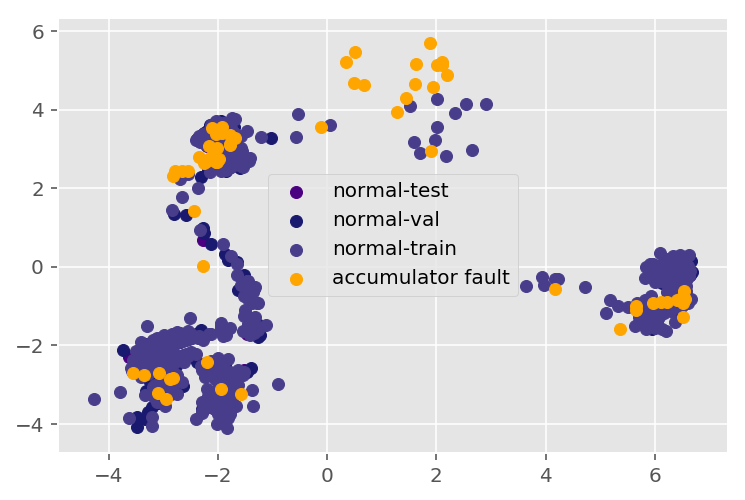

In [65]:
plt.scatter(test_pca[norm_mask, 0], test_pca[norm_mask, 1],
            c='indigo', label='normal-test')
plt.scatter(val_pca[:, 0], val_pca[:, 1],
            c='midnightblue', label='normal-val')
plt.scatter(train_pca[:, 0], train_pca[:, 1],
            c='darkslateblue', label='normal-train')
plt.scatter(test_pca[fail_mask, 0], test_pca[fail_mask, 1],
            c='orange', label=desc + ' fault')
plt.legend()

Get an example of a fault plot and a normal plot.

In [66]:
f_ex = None
n_ex = None
for X, y in test_dl:
    if y == 0 and f_ex is None:
        f_ex = X[0, :, :].cpu().detach().numpy()
    if y == 1 and n_ex is None:
        n_ex = X[0, :, :].cpu().detach().numpy()
    if f_ex is not None and n_ex is not None:
        break
print(f_ex.shape, n_ex.shape)

(14, 512) (14, 512)


(-25.55, 536.55, -0.05, 1.05)

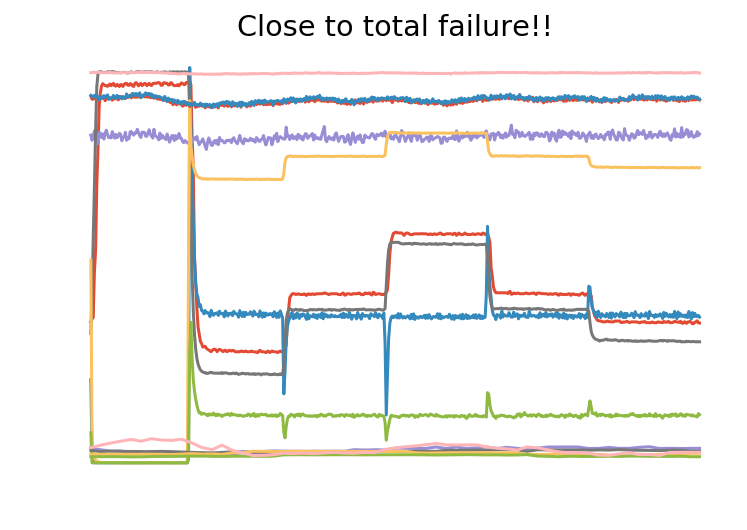

In [67]:
for i in range(f_ex.shape[0]):
    plt.plot(f_ex[i, :])
plt.title('Close to total failure!!')
plt.axis('off')

(-25.55, 536.55, -0.04951599538326264, 1.0398359030485154)

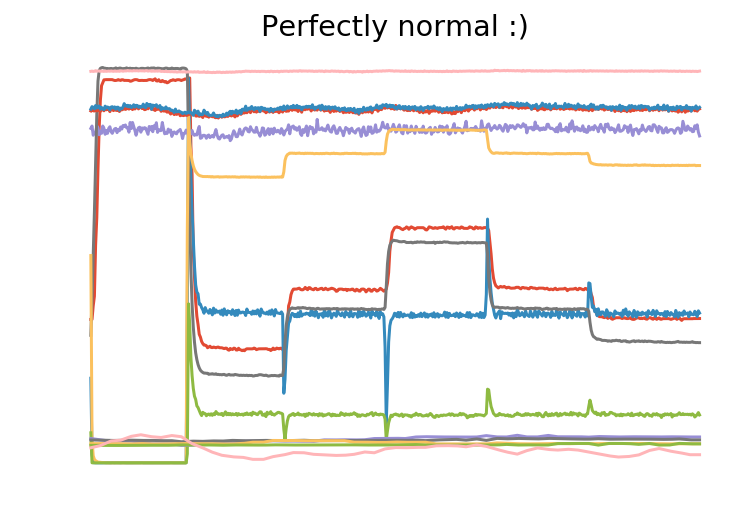

In [68]:
for i in range(n_ex.shape[0]):
    plt.plot(n_ex[i, :])
plt.title('Perfectly normal :)')
plt.axis('off')